<h1>Setup</h1> 

In [1]:
# Set up parameters
function_no = 5

In [2]:
# Import packages
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import qmc

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    ConstantKernel, Matern, WhiteKernel
)

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Read in Data
# Query path relative to notebook location
file_path_X = f"../data/processed_data/X.npy"
file_path_y = f"../data/processed_data/y.npy"

# Load files
X = np.load(file_path_X, allow_pickle=True).item()
y = np.load(file_path_y, allow_pickle=True).item()

# Select data for the relevant function
X = X[function_no-1]
y = y[function_no-1]

<h2>Run Scripts that Define Functions</h2>

In [4]:
%run "functions/visulisation_functions.ipynb"

In [5]:
%run "functions/acquisition_functions.ipynb"

<h1>Preprocessing</h1>

In [6]:
# Only applied to function 1
if function_no == 1:
    # Re-scale y
    c = np.median(np.abs(y[y != 0]))
    y_transform = np.arcsinh(y / c)
    y_transform = y_transform.reshape(-1, 1)

    # Rotate X
    sqrt2_inv = 1.0 / np.sqrt(2.0)

    def rotate(X):
        #Rotate X from (x1, x2) to (u, v)
        u = (X[:, 0] + X[:, 1]) * sqrt2_inv
        v = (X[:, 0] - X[:, 1]) * sqrt2_inv
        return np.column_stack([u, v])

    def inverse_rotate(Z):
        #Inverse rotation from (u, v) back to (x1, x2)
        x1 = (Z[:, 0] + Z[:, 1]) * SQRT2_INV
        x2 = (Z[:, 0] - Z[:, 1]) * SQRT2_INV
        return np.column_stack([x1, x2])

    X_transform = rotate(X)

else:
   y_transform = y
   X_transform = X

<h1>Explore Data</h1>

In [7]:
# Calculate number of dimesions
dimensions = X.shape[1]
print(f"Number of Dimensions = {dimensions}") 

Number of Dimensions = 4


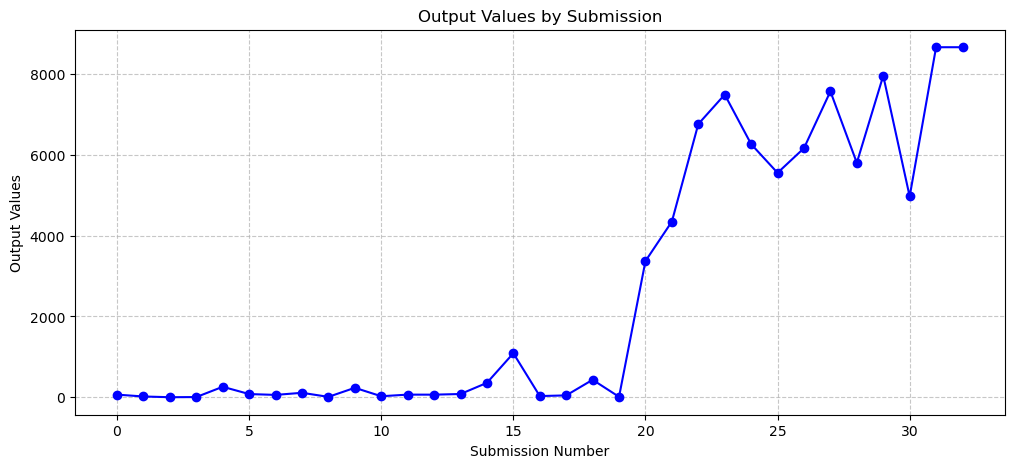

In [8]:
# Plot Output over Time (Includes Initial Data and Submissions)
y_over_time(y_transform)

In [9]:
# Plot top results with colour coding
# Sorted Dataframe
df = pd.DataFrame(X)
df["y"] = y.ravel()

# Sort by highest y
df_sorted = df.sort_values("y", ascending=False)

# Display top ? results with colour bar, change number of rows using head parameter
# axis = 0 colours are scaled across all X data in the top ? rows
# axis = 1 independent colour bar for each row
# axis = None independent colour bar for each column

styled_df_all = styled_top_rows(df_sorted,5,None)
styled_df_row = styled_top_rows(df_sorted,5,1)
styled_df_col = styled_top_rows(df_sorted,5,0)

display(styled_df_all)
display(styled_df_row)
display(styled_df_col)

,0,1,2,3,y
32,0.999999,0.999999,0.999999,0.999999,8662.405001
31,0.999995,0.999995,0.999995,0.999995,8662.095012
29,0.992387,0.997393,0.976028,0.996053,7957.045172
27,0.989363,0.981609,0.985253,0.984120,7569.696665
23,0.986120,0.990625,0.989943,0.968635,7490.490523


,0,1,2,3,y
32,0.999999,0.999999,0.999999,0.999999,8662.405001
31,0.999995,0.999995,0.999995,0.999995,8662.095012
29,0.992387,0.997393,0.976028,0.996053,7957.045172
27,0.989363,0.981609,0.985253,0.984120,7569.696665
23,0.986120,0.990625,0.989943,0.968635,7490.490523


,0,1,2,3,y
32,0.999999,0.999999,0.999999,0.999999,8662.405001
31,0.999995,0.999995,0.999995,0.999995,8662.095012
29,0.992387,0.997393,0.976028,0.996053,7957.045172
27,0.989363,0.981609,0.985253,0.984120,7569.696665
23,0.986120,0.990625,0.989943,0.968635,7490.490523


In [10]:
# For 2D functions produce a 2D plot where output value is given by the colour bar
if dimensions == 2:
    scatter_plot_2d_w_y_colour(X,y_transform)
    if function_no ==1:
        scatter_plot_2d_w_y_colour(X_transform,y_transform)
        

<h1> Suggest Next Point </h1>

<h2> Create Candidate Points </h2>

In [11]:
# Create candidate points for the next query
sampler = qmc.Sobol(d=dimensions, scramble=True)
candidates_no_transformation = sampler.random_base2(18)
 
if function_no == 1:
    candidates = rotate(candidates_no_transformation)
    
else:
    candidates = candidates_no_transformation.copy()

print(candidates_no_transformation.shape)

(262144, 4)


<h2> Standard Sklearn Gaussian Process</h2>

In [12]:
# Nested dictionary of matern kernel parameters for sklearn including:
# length scale bounds, nu, inital noise level and noise level bounds
sk_learn_kernel_parameters = {
    1: {"ls_l": 0.01, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.001},
    2: {"ls_l": 0.01, "ls_u": 0.5, "nu": 2.5, "nl": 0.5, "nl_l": 0.1, "nl_u": 1},
    3: {"ls_l": 0.01, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 1},
    4: {"ls_l": 0.01, "ls_u": 0.8, "nu": 1.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.1},
    5: {"ls_l": 0.0001, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.1},
    6: {"ls_l": 0.01, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.1},
    7: {"ls_l": 0.01, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.1},
    8: {"ls_l": 0.01, "ls_u": 1.5, "nu": 2.5, "nl": 0.1, "nl_l": 0.0001, "nl_u": 0.1},
}

In [13]:
# Standard Sklearn
# Assumes homoscedasticity, spread of variance is the same across all inputs.
# Assumes the function is stationary, statistical properties are constant across all inputs.

params = sk_learn_kernel_parameters[function_no]

kernel = ConstantKernel(1.0, (1e-5, 1e5)) * (Matern(length_scale=(np.ones(dimensions)* 0.1),
                                                    length_scale_bounds=[(params["ls_l"],params["ls_u"])]*dimensions,
                                                    nu = params["nu"]))\
           + WhiteKernel(noise_level = params["nl"], noise_level_bounds=(params["nl_l"],params["nl_u"]))

gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y = True,
    n_restarts_optimizer = 30)

gpr.fit(X_transform, y_transform)

print(
    f"Kernel parameters after fit: \n{gpr.kernel_} \n\n"
    f"Log-likelihood:\n {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f} \n"
)

/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel parameters after fit: 
3.3**2 * Matern(length_scale=[1.5, 1.5, 1.49, 1.41], nu=2.5) + WhiteKernel(noise_level=0.0001) 

Log-likelihood:
 -0.943 



/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [14]:
# Leave One Out Cross Validation for Standard Sklearn
# (Relatively slow to run)
loo = LeaveOneOut()
y_true, y_loo_pred_mean, y_loo_pred_std = [], [], []

for train_idx, test_idx in loo.split(X_transform):
    # Refit GP
    gpr_loo = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=30)
    
    # For clarity, hide warnings in LOO loop
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", ConvergenceWarning)
        gpr_loo.fit(X_transform[train_idx], y_transform[train_idx])
        
    # Predict held out point
    pred, std = gpr_loo.predict(X_transform[test_idx], return_std=True)

    y_true.append(y_transform[test_idx][0])
    y_loo_pred_mean.append(pred[0])
    y_loo_pred_std.append(std[0])

# Convert lists to arrays
y_true = np.array(y_true).reshape(-1, 1)
y_loo_pred_mean = np.array(y_loo_pred_mean).reshape(-1, 1)
y_loo_pred_std = np.array(y_loo_pred_std).reshape(-1, 1)

# Calculate difference between actual and predicted values
loo_residuals = y_true - y_loo_pred_mean
loo_std_residuals = loo_residuals / y_loo_pred_std

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_loo_pred_mean))

print(f"Leave One Out Cross Validation (LOO):")
print(f"Root Mean Squared Error for LOO: {rmse:.4f}")
print(f"Mean for standardised LOO residual: {np.mean(loo_std_residuals):.4f}") # expect 0
print(f"Std for standardised LOO residual: {np.std(loo_std_residuals, ddof=1):.4f}") # expect 1 

Leave One Out Cross Validation (LOO):
Root Mean Squared Error for LOO: 283.2595
Mean for standardised LOO residual: 0.0022
Std for standardised LOO residual: 0.9197


In [15]:
# Calculate the mean and standard deviation using standard Sklearn GP trained earlier

post_mean_standard_GP, post_std_standard_GP = gpr.predict(candidates, return_std=True)

standard_GP = acquisition_function_results(post_mean = post_mean_standard_GP,
                                         post_std = post_std_standard_GP,
                                         candidates_no_transformation = candidates_no_transformation,
                                         beta = 0.25, #Tune to change exploration-exploitation balance for UCB
                                         y_transform = y_transform,
                                         eps = 1e-9,
                                         eta = 0.05 #Tune to change exploration-exploitation balance for PI
                                        )

Next point to explore maximising UCB acqusition function for Standard GP:
[0.95824576 0.97106457 0.98656161 0.99284592]
    predicted mean: 7073.315, predicted std: 39.433

Next point to explore maximising EI acqusition function for Standard GP:
[0.97700689 0.96350381 0.99113144 0.01339715]
    predicted mean: 3874.523, predicted std: 2468.424

Next point to explore maximising PI acqusition function for Standard GP:
[0.97700689 0.96350381 0.99113144 0.01339715]
    predicted mean: 3874.523, predicted std: 2468.424



In [16]:
# For ucb acquisiton function explore the impact of different values for beta
# Set range of beta values to test
beta_values = np.linspace(0.0, 5.0, 25)  # 50 beta values from 0 to 5
max_points = 8

selected_points = []

print("Unique candidate points suggested by UCB with Standard GP for different beta values:\n")

for beta in beta_values:
    # Calculate UCB acquisition values
    ucb_values = ucb(post_mean_standard_GP, post_std_standard_GP, beta)
    
    # Select the candidate with maximum UCB
    next_point = candidates_no_transformation[np.argmax(ucb_values)]
    
    # Check if this point is new
    if len(selected_points) == 0 or not any(np.allclose(next_point, p) for p in selected_points):
        selected_points.append(next_point)
        print(f"Beta = {beta:.3f} -> Next candidate point: {', '.join([f'{x:.6f}' for x in next_point])}")
    
    # Stop if we have reached the maximum number of points
    if len(selected_points) >= max_points:
        break

Unique candidate points suggested by UCB with Standard GP for different beta values:

Beta = 0.000 -> Next candidate point: 0.958246, 0.971065, 0.986562, 0.992846
Beta = 1.458 -> Next candidate point: 0.977007, 0.963504, 0.991131, 0.013397
Beta = 3.333 -> Next candidate point: 0.001195, 0.064689, 0.994279, 0.994008


In [17]:
# For chosen point compare to best known point and closest point already explored
# Choose suggested point
point_for_comparision = standard_GP['ucb']['x_next'] #Change point if required

print(f"Suggested exploration point:\n{point_for_comparision}\n")

# Compare with best existing point
best_idx = np.argmax(y)
best_point = X[best_idx]
best_point_outcome = y[best_idx]
print(f"Best known point:\n{best_idx},{best_point}, {best_point_outcome}\n")

# Calculate Euclidean distance to best known point
difference_to_best_point = np.linalg.norm(point_for_comparision - best_point)
print(f"For the chosen acquistion function the Euclidean distance to the best known point is:\n{difference_to_best_point:.4f}\n")
print(f"The difference per dimension is:\n{point_for_comparision - best_point}\n\n")


# Compare with closest existing point (Euclidean distance)
diff_to_each_known_point = (X - point_for_comparision)
euclidean_distance_to_each_known_point = np.linalg.norm(diff_to_each_known_point, axis=1)

closest_idx = euclidean_distance_to_each_known_point.argmin()
closest_point = X[closest_idx]
closest_point_outcome = y[closest_idx]

print(f"For the chosen acquistion function the closest explored point is:\n{closest_idx},{closest_point},{closest_point_outcome:.4f}\n")
print(f"The euclidean distance is:\n{euclidean_distance_to_each_known_point[closest_idx]}\n")
print(f"The difference per dimension is:\n{point_for_comparision - closest_point}\n")

Suggested exploration point:
[0.95824576 0.97106457 0.98656161 0.99284592]

Best known point:
32,[0.999999 0.999999 0.999999 0.999999], 8662.405001248297

For the chosen acquistion function the Euclidean distance to the best known point is:
0.0530

The difference per dimension is:
[-0.04175324 -0.02893443 -0.01343739 -0.00715308]


For the chosen acquistion function the closest explored point is:
22,[0.942536 0.961395 0.986174 0.998521],6760.7008

The euclidean distance is:
0.019304244680905802

The difference per dimension is:
[ 0.01570976  0.00966957  0.00038761 -0.00567508]



<h2> Manual Point Creation </h2>

In [18]:
# Where there are neighbouring datapoints with promising results, construct a new point to query using
# the difference between points
# any general observed patterns
best_idx = np.argmax(y)
next_best_idx = np.argsort(y)[-2]
third_best_idx = np.argsort(y)[-3]

print(f"Best Point: {best_idx}, {X[best_idx]}, {y[best_idx]:.4f}\n")
print(f"Next Best Point: {next_best_idx}, {X[next_best_idx]}, {y[next_best_idx]:.4f}\n")
print(f"Third Best Point: {third_best_idx}, {X[third_best_idx]}, {y[third_best_idx]:.4f}\n")

change = X[best_idx]-X[next_best_idx]
print(f"Change Between Points: {change}\n")

# Example Changes
#x_next_manual = X[best_idx] - (change/2) 
#x_next_manual = X[best_idx][0] + (change[0]/2), X[best_idx][1] + (change[1]/2), 0.5
#x_next_manual = X[best_idx] + (change/4) 
x_next_manual = X[best_idx] - (change/2)


print(f"Suggested Point to Query Next:{x_next_manual}\n")

# Compare with closest existing point (Euclidean distance)
diff_to_each_known_point = (X - x_next_manual)
euclidean_distance_to_each_known_point = np.linalg.norm(diff_to_each_known_point, axis=1)

closest_idx = euclidean_distance_to_each_known_point.argmin()
closest_point = X[closest_idx]

print(f"For the chosen acquistion function the closest explored point is:\n{closest_idx},{closest_point}\n")
print(f"The euclidean distance is:\n{euclidean_distance_to_each_known_point[closest_idx]}\n")
print(f"The difference per dimension is:\n{x_next_manual - closest_point}\n")

Best Point: 32, [0.999999 0.999999 0.999999 0.999999], 8662.4050

Next Best Point: 31, [0.999995 0.999995 0.999995 0.999995], 8662.0950

Third Best Point: 29, [0.992387 0.997393 0.976028 0.996053], 7957.0452

Change Between Points: [4.e-06 4.e-06 4.e-06 4.e-06]

Suggested Point to Query Next:[0.999997 0.999997 0.999997 0.999997]

For the chosen acquistion function the closest explored point is:
32,[0.999999 0.999999 0.999999 0.999999]

The euclidean distance is:
3.999999999892978e-06

The difference per dimension is:
[-2.e-06 -2.e-06 -2.e-06 -2.e-06]



<h2> Sklearn Gaussian Process for Selected Region </h2>

In [23]:
# Run the same code as the Sklearn standard Guassian Process but train on only a specific sample of the data
# Use only for funtion 5, could be applied to other unknown functions, however function 5 has the clearest structure 
# where this may be an appropriate method.

# A trust region approach would likley be superior e.g. TuRBO in BOTorch 

if function_no == 5:
    # Create a new training dataset with only values where y>7000
    X_s = df_sorted.loc[df_sorted['y'] > 7000, [0, 1, 2, 3]].to_numpy()
    y_s = df_sorted.loc[df_sorted['y'] > 7000, 'y'].to_numpy()

    # Standard Sklearn
    # Assumes homoscedasticity, spread of variance is the same across all inputs.
    # Assumes the function is stationary, statistical properties are constant across all inputs.
    
    params = sk_learn_kernel_parameters[function_no]
    
    kernel = ConstantKernel(1.0, (1e-5, 1e5)) * (Matern(length_scale=(np.ones(dimensions)* 0.1),
                                                        length_scale_bounds=[(params["ls_l"],params["ls_u"])]*dimensions,
                                                        nu = params["nu"]))\
               + WhiteKernel(noise_level = params["nl"], noise_level_bounds=(params["nl_l"],params["nl_u"]))
    
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y = True,
        n_restarts_optimizer = 30)
    
    gpr.fit(X_s, y_s)
    
    print(
        f"Kernel parameters after fit: \n{gpr.kernel_} \n\n"
        f"Log-likelihood:\n {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f} \n"
    )

    # Create candidate points with scaling
    sampler = qmc.Sobol(d=dimensions, scramble=True)
    candidates_base = sampler.random_base2(18)

    X_min = X_s.min(axis=0)
    
    candidates_scaled = X_min + candidates_base * (1.0 - X_min)
    
    # Leave One Out Cross Validation for Standard Sklearn
    # (Relatively slow to run)
    loo = LeaveOneOut()
    y_true, y_loo_pred_mean, y_loo_pred_std = [], [], []
    
    for train_idx, test_idx in loo.split(X_s):
        # Refit GP
        gpr_loo = GaussianProcessRegressor(
            kernel=kernel,
            normalize_y=True,
            n_restarts_optimizer=30)
        
        # For clarity, hide warnings in LOO loop
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            gpr_loo.fit(X_s[train_idx], y_s[train_idx])
            
        # Predict held out point
        pred, std = gpr_loo.predict(X_s[test_idx], return_std=True)
    
        y_true.append(y_s[test_idx][0])
        y_loo_pred_mean.append(pred[0])
        y_loo_pred_std.append(std[0])
    
    # Convert lists to arrays
    y_true = np.array(y_true).reshape(-1, 1)
    y_loo_pred_mean = np.array(y_loo_pred_mean).reshape(-1, 1)
    y_loo_pred_std = np.array(y_loo_pred_std).reshape(-1, 1)
    
    # Calculate difference between actual and predicted values
    loo_residuals = y_true - y_loo_pred_mean
    loo_std_residuals = loo_residuals / y_loo_pred_std
    
    # LOO Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_loo_pred_mean))
    
    print(f"Leave One Out Cross Validation (LOO):")
    print(f"Root Mean Squared Error for LOO: {rmse:.4f}")
    print(f"Mean for standardised LOO residual: {np.mean(loo_std_residuals):.4f}") # expect 0
    print(f"Std for standardised LOO residual: {np.std(loo_std_residuals, ddof=1):.4f}\n") # expect 1 

    # Calculate the mean and standard deviation using standard Sklearn GP trained earlier
    post_mean_selected_region_GP, post_std_selected_region_GP = gpr.predict(candidates_scaled, return_std=True)
    
    selected_region_GP = acquisition_function_results(post_mean = post_mean_selected_region_GP,
                                         post_std = post_std_selected_region_GP,
                                         candidates_no_transformation = candidates_scaled,
                                         beta = 0.25, #Tune to change exploration-exploitation balance for UCB
                                         y_transform = y_s,
                                         eps = 1e-9,
                                         eta = 0.05 #Tune to change exploration-exploitation balance for PI
                                        )

/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1.5. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/s

Kernel parameters after fit: 
1.05**2 * Matern(length_scale=[0.00844, 1.5, 1.5, 1.5], nu=2.5) + WhiteKernel(noise_level=0.0001) 

Log-likelihood:
 -0.305 

Leave One Out Cross Validation (LOO):
Root Mean Squared Error for LOO: 70.7034
Mean for standardised LOO residual: -0.3677
Std for standardised LOO residual: 1.1720

Next point to explore maximising UCB acqusition function for Standard GP:
[0.99999056 0.98327774 0.97687545 0.97043007]
    predicted mean: 8661.588, predicted std: 19.937

Next point to explore maximising EI acqusition function for Standard GP:
[0.99857407 0.98269358 0.9773321  0.96886396]
    predicted mean: 8615.173, predicted std: 77.435

Next point to explore maximising PI acqusition function for Standard GP:
[0.99999918 0.99817179 0.98086223 0.99924567]
    predicted mean: 8662.249, predicted std: 10.848



<h2> Sklearn Gaussian Process with Clustering</h2>

In [20]:
# Mainly used for reference
# A trust region approach would likley be superior e.g. TuRBO in BOTorch 
class HardPartitionGP:
    """Hard-partition piecewise Gaussian Process using K-means clustering - Generated using AI"""
    
    def __init__(self, n_partitions=3, kernel=None, n_restarts_optimizer=5):
        self.n_partitions = n_partitions
        self.kernel = kernel
        self.n_restarts_optimizer = n_restarts_optimizer
        self.kmeans = None
        self.gp_models = {}
        
    def fit(self, X, y):
        """Fit the hard-partition GP model"""
        # Perform K-means clustering to create hard partitions
        self.kmeans = KMeans(n_clusters=self.n_partitions, random_state=42, n_init=10)
        partition_labels = self.kmeans.fit_predict(X)
        
        # Train a separate GP for each partition
        for partition_id in range(self.n_partitions):
            mask = partition_labels == partition_id
            X_partition = X[mask]
            y_partition = y[mask]
            
            print(f"Partition {partition_id}: {np.sum(mask)} samples")
            
            # Define kernel for this partition if not provided
            if self.kernel is None:
                kernel = ConstantKernel(1.0, (1e-5, 1e5)) * (Matern(length_scale=(np.ones(dimensions)* 0.1),
                                                    length_scale_bounds=[(0.01,2)]*dimensions,
                                                    nu = 2.5))\
                        + WhiteKernel(noise_level = 0.1, noise_level_bounds=(0.0001, 0.1))
            else:
                kernel = self.kernel
            
            # Create and fit GP for this partition
            gp = GaussianProcessRegressor(
                kernel=kernel,
                n_restarts_optimizer=self.n_restarts_optimizer,
                alpha=1e-6,
                normalize_y=True
            )
            gp.fit(X_partition, y_partition)
            
            self.gp_models[partition_id] = {
                'model': gp,
                'n_samples': np.sum(mask),
                'mean_y': np.mean(y_partition)
            }
            
        return self
    
    def predict(self, X, return_std=False):
        """Predict using the appropriate GP based on partition assignment"""
        # Assign each point to nearest partition
        partition_labels = self.kmeans.predict(X)
        
        y_pred = np.zeros(len(X))
        if return_std:
            y_std = np.zeros(len(X))
        
        # Make predictions using the appropriate GP for each partition
        for partition_id in range(self.n_partitions):
            mask = partition_labels == partition_id
            if np.sum(mask) > 0:
                X_partition = X[mask]
                gp = self.gp_models[partition_id]['model']
                
                if return_std:
                    pred, std = gp.predict(X_partition, return_std=True)
                    y_pred[mask] = pred
                    y_std[mask] = std
                else:
                    y_pred[mask] = gp.predict(X_partition)
        
        if return_std:
            return y_pred, y_std
        return y_pred
    
    def get_partition_info(self):
        """Get information about each partition"""
        info = []
        for partition_id in range(self.n_partitions):
            model_info = self.gp_models[partition_id]
            info.append({
                'partition': partition_id,
                'n_samples': model_info['n_samples'],
                'mean_y': model_info['mean_y'],
                'kernel': str(model_info['model'].kernel_)
            })
        return info


# Create and fit the hard-partition GP model
print("="*70)
print("Fitting Hard-Partition Piecewise Gaussian Process")
print("="*70)

n_partitions = 4  # Tune to adjust number of partitions
hp_gp = HardPartitionGP(n_partitions=n_partitions, n_restarts_optimizer=10)
hp_gp.fit(X, y)

print("\n" + "="*70)
print("Partition Information:")
print("="*70)
for info in hp_gp.get_partition_info():
    print(f"\nPartition {info['partition']}:")
    print(f"  Samples: {info['n_samples']}")
    print(f"  Mean y: {info['mean_y']:.2f}")
    print(f"  Kernel: {info['kernel']}\n")

# Make predictions on candidate points
post_mean_p_gp, post_std_p_gp = hp_gp.predict(candidates, return_std=True)
new_partitions = hp_gp.kmeans.predict(candidates)

# Apply acquistion function
pi_acquisition_function = probability_improvement(y, post_mean_p_gp, post_std_p_gp, eta =0.05)

ucb_acquistion_function = ucb(post_mean_p_gp, post_std_p_gp, beta=0.25)

expected_improvement_function = expected_improvement(post_mean_p_gp, post_std_p_gp, y_train = y, eps=1e-9)

# Maximise acquistion function
x_next_pi = candidates_no_transformation[np.argmax(pi_acquisition_function)]
x_next_ucb = candidates_no_transformation[np.argmax(ucb_acquistion_function)]
x_next_ei = candidates_no_transformation[np.argmax(expected_improvement_function)]

print(f"next point to explore maximising probability of improvement acqusition function:\n{x_next_pi:}")
print(f"next point to explore maximising UCB acqusition function:\n{x_next_ucb:}")
print(f"next point to explore maximising EI acqusition function:\n{x_next_ei:}")

Fitting Hard-Partition Piecewise Gaussian Process
Partition 0: 1 samples
Partition 1: 2 samples
Partition 2: 1 samples
Partition 3: 1 samples

Partition Information:

Partition 0:
  Samples: 1
  Mean y: 7569.70
  Kernel: 0.00316**2 * Matern(length_scale=[0.1, 0.1, 0.1, 0.1], nu=2.5) + WhiteKernel(noise_level=0.0001)


Partition 1:
  Samples: 2
  Mean y: 8662.25
  Kernel: 0.00316**2 * Matern(length_scale=[0.0155, 0.011, 0.296, 0.0105], nu=2.5) + WhiteKernel(noise_level=0.1)


Partition 2:
  Samples: 1
  Mean y: 7957.05
  Kernel: 0.00316**2 * Matern(length_scale=[0.1, 0.1, 0.1, 0.1], nu=2.5) + WhiteKernel(noise_level=0.0001)


Partition 3:
  Samples: 1
  Mean y: 7490.49
  Kernel: 0.00316**2 * Matern(length_scale=[0.1, 0.1, 0.1, 0.1], nu=2.5) + WhiteKernel(noise_level=0.0001)

next point to explore maximising probability of improvement acqusition function:
[0.86572645 0.23634066 0.86001411 0.38623037]
next point to explore maximising UCB acqusition function:
[0.45226595 0.52243408 0.74152

/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/Course/lib/python

<h2> Random Forest </h2>

In [24]:
# Mainly used for reference
"""Random Forest  - Generated using AI"""

rf = RandomForestRegressor(
    n_estimators=400,          
    min_samples_leaf=4,
    max_depth = 6,
    max_features=None,
    bootstrap=True,
    random_state=0,
    
)

rf.fit(X, y.ravel())
print ('Full tree guess train/validation ',rf.score(X, y))

def rf_predict_mean_std(rf, X):
    # predictions from each tree
    tree_preds = np.array([tree.predict(X) for tree in rf.estimators_])

    mean = tree_preds.mean(axis=0)
    std = tree_preds.std(axis=0) + 1e-6

    return mean, std

post_mean, post_std = rf_predict_mean_std(rf,X)

print("Mean of mean near data:", post_mean.mean())
print("Mean std near data:", post_std.mean())
print("Min std:", post_std.min())
print("Max std:", post_std.max())


X_rand = np.random.uniform(0,1,(5000,dimensions))
_, std_rand = rf_predict_mean_std(rf, X_rand)
print("Mean std (random points):", std_rand.mean())

# Apply to candidate points
post_mean_rf, post_std_rf = rf_predict_mean_std(rf,candidates)

# Apply acquistion functions
pi_acquisition_function = probability_improvement(y, post_mean_rf, post_std_rf, eta =0.5)

ucb_acquistion_function = ucb(post_mean_rf, post_std_rf, beta=0.5)

expected_improvement_function = expected_improvement(post_mean_rf, post_std_rf, y, eps=1e-9)

# Maximise acquistion function
x_next_pi = candidates_no_transformation[np.argmax(pi_acquisition_function)]
x_next_ucb = candidates_no_transformation[np.argmax(ucb_acquistion_function)]
x_next_ei = candidates_no_transformation[np.argmax(expected_improvement_function)]

print(f"\nnext point to explore maximising probability of improvement acqusition function:\n{x_next_pi:}")
print(f"next point to explore maximising UCB acqusition function:\n{x_next_ucb:}")
print(f"next point to explore maximising EI acqusition function:\n{x_next_ei:}")


Full tree guess train/validation  -0.00014005126444249782
Mean of mean near data: 8074.381748761339
Mean std near data: 226.7969072115674
Min std: 226.79690721156737
Max std: 226.79690721156737
Mean std (random points): 226.7969072115674

next point to explore maximising probability of improvement acqusition function:
[0.86572645 0.23634066 0.86001411 0.38623037]
next point to explore maximising UCB acqusition function:
[0.86572645 0.23634066 0.86001411 0.38623037]
next point to explore maximising EI acqusition function:
[0.86572645 0.23634066 0.86001411 0.38623037]
